In [1]:
%matplotlib inline

from matplotlib import style
style.use('fivethirtyeight')
from sqlalchemy.sql import func
from matplotlib.dates import DateFormatter
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, inspect
import matplotlib.dates as mdates
from scipy import stats
import scipy
from statistics import mean, stdev

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
from datetime import datetime
from datetime import date, timedelta

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

In [6]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)
# reflect the tables

In [7]:
# We can view all of the classes that automap found

Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement=Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
inspector = inspect(engine)

In [11]:
inspector.get_table_names()

['measurement', 'station']

In [12]:
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


# Exploratory Climate Analysis

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
last_data_point = session.query(Measurement.date).order_by((Measurement.date).desc()).first()
last_data_date = datetime.strptime(last_data_point[0], '%Y-%m-%d')
print(f"The last data point is {last_data_date}")
# Calculate the date 1 year ago from the last data point in the database
a_year_ago = last_data_date - dt.timedelta(days=365)
print(a_year_ago)
# Perform a query to retrieve the data and precipitation scores
year_prcp = session.query(Measurement.date,Measurement.prcp).\
                filter(Measurement.date >= a_year_ago).all()
#print(year_prcp)

The last data point is 2017-08-23 00:00:00
2016-08-23 00:00:00


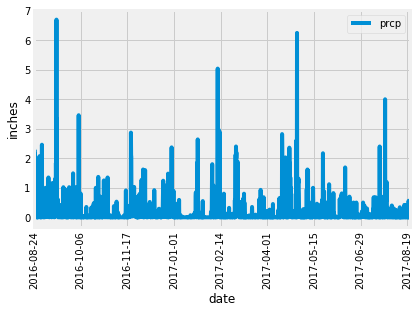

In [14]:
# Save the query results as a Pandas DataFrame and set the index to the date column
sql_str = "SELECT date, prcp FROM Measurement WHERE date >= '%s' order by date; " % a_year_ago
#print(sql_str)

#Load the result into Pandas Dataframe
data = pd.read_sql(sql_str, conn)
data=data.set_index('date')
data

# Sort the dataframe by date
sorting_df = data.sort_values("date")
new_prcp_df=sorting_df.dropna()
new_prcp_df

# Use Pandas Plotting with Matplotlib to plot the data
new_prcp_df.plot(rot=90)
plt.xlabel("date")
plt.ylabel("inches")
plt.show()


In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data
print("Summary statistics for the precipitation data:")
new_prcp_df["prcp"].describe()

Summary statistics for the precipitation data:


count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: prcp, dtype: float64

In [16]:
# Design a query to show how many stations are available in this dataset?
number_of_station =session.query (Station. station).count()
print(f"{number_of_station} stations are available in this dataset")

9 stations are available in this dataset


In [17]:
# What are the most active stations? (i.e. what stations have the most rows)?

most_active_station = session.query(Measurement.station,func.count(Measurement.tobs)).\
    group_by (Measurement.station).\
    order_by (func.count(Measurement.tobs).desc()).first()
print(f"The most active station is {most_active_station[0]}")

# List the stations and the counts in descending order.
session.query(Measurement.station,func.count(Measurement.tobs)).\
    group_by (Measurement.station).\
    order_by (func.count(Measurement.tobs).desc()).all()

The most active station is USC00519281


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [18]:
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [19]:
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [20]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
print(f"The most active station is {most_active_station[0]}")
tob_most_available_lowest =session.query(func.min(Measurement.tobs)).\
            filter(Measurement.station == most_active_station[0]).all()

print(f"The lowest temperature recorded of {most_active_station[0]} is {tob_most_available_lowest[0][0]}.")
tob_most_available_highest =session.query(func.max(Measurement.tobs)).\
            filter(Measurement.station == most_active_station[0]).all()
print(f"The highest temperature recorded of {most_active_station[0]} is {tob_most_available_highest[0][0]}.")
tob_most_available_average =session.query(func.avg(Measurement.tobs)).\
            filter(Measurement.station == most_active_station[0]).all()
print(f"The average temperature recorded of {most_active_station[0]} is {tob_most_available_average[0][0]}.")
#lowest_temp = func.avg(tob_most_available)
#print(lowest_temp)
#print(f"The most active station is {most_active_station[0]}"


The most active station is USC00519281
The lowest temperature recorded of USC00519281 is 54.0.
The highest temperature recorded of USC00519281 is 85.0.
The average temperature recorded of USC00519281 is 71.66378066378067.


In [21]:
# Choose the station with the highest number of temperature observations.
print(f"The most active station is {most_active_station[0]}")
# Query the last 12 months of temperature observation data for this station
year_tobs = session.query(Measurement.date,Measurement.tobs,Measurement.station).\
                filter(Measurement.date >= a_year_ago).\
                filter(Measurement.station == most_active_station[0]).all()
#print(year_tobs)



The most active station is USC00519281


In [22]:
tobs = [result[1] for result in year_tobs]
#print(tobs)


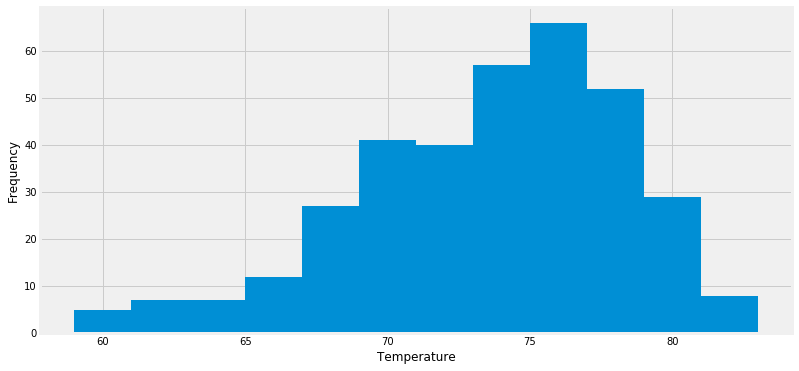

In [23]:
#plot the results of query as a histogram
plt.figure(figsize=(12,6))
plt.hist(tobs, bins=12)
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.show()

## Bonus Challenge Assignment

In [24]:
#Hawaii is reputed to enjoy mild weather all year. 
#Is there a meaningful difference between the temperature in, for example, June and December?
#read csv
hawaii_path="Resources/hawaii_measurements.csv"
hawaii_df = pd.read_csv(hawaii_path)

#Identify the average temperature in June at all stations across all available years in the dataset. 
#Do the same for December temperature.
June_df = hawaii_df[pd.to_datetime(hawaii_df['date']).dt.month == 6]
December_df = hawaii_df[pd.to_datetime(hawaii_df['date']).dt.month == 12]

avg_june=June_df["tobs"].mean()
print(f"Average temperature of June is {avg_june}")
avg_Dec=December_df["tobs"].mean()
print(f"Average temperature of Devember is {avg_Dec}")


Average temperature of June is 74.94411764705882
Average temperature of Devember is 71.04152933421226


In [25]:
#Use the t-test to determine whether the difference in the means, if any, is statistically significant. 
#Will you use a paired t-test, or an unpaired t-test? 
#Why?
print( "I used unpaired t-test becuase these two data are independent of each other")
result = stats.ttest_ind(June_df.tobs, December_df.tobs, equal_var=False)
print(f"The t-test reult : {result} ")
print("There is meaningful difference between the temperature in June and December")

I used unpaired t-test becuase these two data are independent of each other
The t-test reult : Ttest_indResult(statistic=31.355036920962423, pvalue=4.193529835915755e-187) 
There is meaningful difference between the temperature in June and December


In [26]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).\
        filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [27]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_start_date = '2012-08-01'
trip_end_date = '2012-08-10'
trip_temps = calc_temps(trip_start_date,trip_end_date)
print(f"The minimum temperature of trip dates in 2012 is {trip_temps[0][0]}.")
print(f"The average temperature of trip dates in 2012 is {trip_temps[0][1]}.")
print(f"The maximum temperature of trip dates in 2012 is {trip_temps[0][2]}.")

The minimum temperature of trip dates in 2012 is 65.0.
The average temperature of trip dates in 2012 is 74.640625.
The maximum temperature of trip dates in 2012 is 82.0.


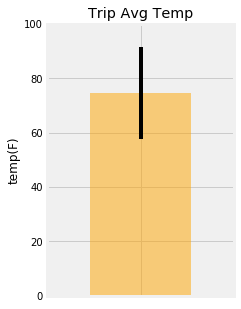

In [28]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.figure(figsize=(3,5))
xaxis = [""]
yaxis = trip_temps[0][1]
plt.bar(xaxis,yaxis,color='orange',alpha=0.5)
difference=trip_temps[0][2]-trip_temps[0][0]
plt.errorbar(xaxis,yaxis,yerr=difference,color='black')
plt.ylabel("temp(F)")
plt.title("Trip Avg Temp")
plt.ylim(0,100)
plt.xlim(-0.75,0.75)
plt.show()

In [29]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

sel = [Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation]
join = session.query(func.sum(Measurement.prcp),*sel).\
        group_by(Measurement.station).\
        order_by (func.sum(Measurement.prcp).desc()).\
        filter(Measurement.station == Station.station).\
        filter(Measurement.date >= trip_start_date).\
        filter(Measurement.date <= trip_end_date).all()
print(join)


[(1.7599999999999998, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4), (0.3, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9), (0.28, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6), (0.26, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6), (0.11, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5), (0.02, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0), (0.01, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9), (None, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0)]


In [30]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [31]:
# Set the start and end date of the trip

sdate = date(2012, 8, 1)   # start date
edate = date(2012, 8, 10)   # end date

# Use the start and end date to create a range of dates
delta = edate - sdate       # as timedelta

# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
# Stip off the year and save a list of %m-%d strings
# Loop through the list of %m-%d strings and calculate the normals for each date
trip_date=["08-%02d" % i for i in range(1,delta.days+2)]
Normals=[]
for date in trip_date:
    normal= daily_normals(date)
    Normals.append(normal)
print(Normals)

[[(67.0, 75.54, 83.0)], [(68.0, 75.60377358490567, 84.0)], [(70.0, 76.61111111111111, 85.0)], [(69.0, 76.71153846153847, 84.0)], [(69.0, 76.14814814814815, 82.0)], [(67.0, 76.25, 83.0)], [(71.0, 77.15686274509804, 83.0)], [(68.0, 76.5576923076923, 83.0)], [(69.0, 75.98039215686275, 81.0)], [(65.0, 76.42, 83.0)]]


In [32]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
minimum = [normal[0][0] for normal in Normals]
average = [normal[0][1] for normal in Normals]
maximum = [normal[0][2]for normal in Normals]

real_date=[]
for  d in trip_date:
    new_d="2020-"+d
    real_date.append(new_d)
d = {'date':real_date,'minimum': minimum, 'average': average,'maximum':maximum}
trip_normal_df = pd.DataFrame(data=d)
trip_normal_df=trip_normal_df.set_index('date')
trip_normal_df

,minimum,average,maximum
date,,,
2020-08-01,67.0,75.540000,83.0
2020-08-02,68.0,75.603774,84.0
2020-08-03,70.0,76.611111,85.0
2020-08-04,69.0,76.711538,84.0
2020-08-05,69.0,76.148148,82.0
2020-08-06,67.0,76.250000,83.0
2020-08-07,71.0,77.156863,83.0
2020-08-08,68.0,76.557692,83.0
2020-08-09,69.0,75.980392,81.0


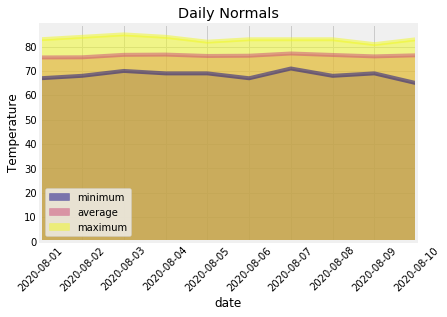

In [33]:
# Plot the daily normals as an area plot with `stacked=False`
trip_normal_df.plot(kind='area', stacked=False,alpha=0.5, colormap='plasma',title='Area Plot')
plt.legend(loc='lower left')
plt.xticks(rotation='45')
plt.ylabel("Temperature")
plt.title("Daily Normals")
plt.show()
